In [1]:
# Import the packages
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import seaborn as sns
from datetime import datetime
import logging
logging.basicConfig(
    filename="bootstrap_analysis_logs.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO",
    encoding="utf-8"
)

In [16]:
# Declare some global inputs
test_data_filters_list = [
    # This is the configuration for one test. If you want to add more tests, please specify the parameters in the same way indicated here
    # PE
    {"entity_id": "PY_PE", "test_name": "PE_20230410_R_B0_O_LovedBrands_AQPv2", "test_start_date": "2023-04-10", "lb_pipeline_run_date": "2023-05-05", "asa_id": ["4"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation1", "Variation2"]},
    
    # TH
    {"entity_id": "FP_TH", "test_name": "TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave", "test_start_date": "2023-06-16", "lb_pipeline_run_date": "2023-07-06", "asa_id": ["2028"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4"]},
    {"entity_id": "FP_TH", "test_name": "TH_20230616_LBs_Maha sarakham_ASA ID 2034_New Wave", "test_start_date": "2023-06-16", "lb_pipeline_run_date": "2023-07-06", "asa_id": ["2034"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4"]},
    {"entity_id": "FP_TH", "test_name": "TH_20230317_LovedBrands_Bangkok_ASA ID 438", "test_start_date": "2023-03-31", "lb_pipeline_run_date": "2023-04-06", "asa_id": ["438"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4", "Variation5"]},
    {"entity_id": "FP_TH", "test_name": "TH_20230331_LBs_Samut Sakhon_ASA ID 795_New Wave", "test_start_date": "2023-03-31", "lb_pipeline_run_date": "2023-04-06", "asa_id": ["795"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4", "Variation5"]},
    {"entity_id": "FP_TH", "test_name": "TH_20230331_LBs_NST_ASA ID 1098_New Wave", "test_start_date": "2023-03-31", "lb_pipeline_run_date": "2023-04-06", "asa_id": ["1098"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4", "Variation5"]},
    {"entity_id": "FP_TH", "test_name": "TH_20230518_LBs_NST_ASA ID 1098_New Wave", "test_start_date": "2023-05-19", "lb_pipeline_run_date": "2023-06-15", "asa_id": ["1098"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation4"]},

    # CR
    {"entity_id": "PY_CR", "test_name": "CR_20230519_R_B0_R_LovedBrandsSanJose_v2", "test_start_date": "2023-05-19", "lb_pipeline_run_date": "2023-06-15", "asa_id": ["15"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation3"]},
    
    # AE
    {"entity_id": "TB_AE", "test_name": "AE_20230616_R_BZ_P_RAK-LoveBrands", "test_start_date": "2023-06-19", "lb_pipeline_run_date": "2023-07-20", "asa_id": ["35"], "lb_designated_tg": "Target Group 1", "nlb_designated_tg": "Target Group 2", "ela_variant": ["Variation1"]},

    # PH
    {"entity_id": "FP_PH", "test_name": "PH_20230202_LovedBrandsDavao", "test_start_date": "2023-02-13", "lb_pipeline_run_date": "2023-03-24", "asa_id": ["10"], "lb_designated_tg": "Target Group 2", "nlb_designated_tg": "Target Group 3", "ela_variant": ["Variation4"]},
    {"entity_id": "FP_PH", "test_name": "PH_20230202_LovedBrandsMisamis oriental", "test_start_date": "2023-02-13", "lb_pipeline_run_date": "2023-03-24", "asa_id": ["185"], "lb_designated_tg": "Target Group 2", "nlb_designated_tg": "Target Group 3", "ela_variant": ["Variation4"]},
    {"entity_id": "FP_PH", "test_name": "PH_20230202_LovedBrandsIloilo", "test_start_date": "2023-02-10", "lb_pipeline_run_date": "2023-03-24", "asa_id": ["25"], "lb_designated_tg": "Target Group 2", "nlb_designated_tg": "Target Group 3", "ela_variant": ["Variation4"]},
    {"entity_id": "FP_PH", "test_name": "PH_20230202_LovedBrands_ASA_547_Marikina", "test_start_date": "2023-02-10", "lb_pipeline_run_date": "2023-03-24", "asa_id": ["547"], "lb_designated_tg": "Target Group 2", "nlb_designated_tg": "Target Group 3", "ela_variant": ["Variation4"]},
]

# Bootstapping inputs
num_bootstrap_samples = 750 # Number of data points to have on the histogram
cl = 0.95 # Confidence interval
left_threshold = round((1 - cl) / 2, 4) # Left threshold of the confidence interval
right_threshold = round((1 - (1 - cl) / 2), 4) # Right threshold of the confidence interval
bootstrap_level = ["user"] # Default is user level. We keep the legacy code that works on order level as well
ela_lower_limit = -10 # This will delete any bootstrapped elasticity value below ela_lower_limit. Used in the plotting step
ela_upper_limit = 10 # This will delete any bootstrapped elasticity value above ela_upper_limit. Used in the plotting step

###--------------------------NO NEED TO CHANGE ANY INPUTS BEYOND THIS POINT--------------------------###

# The vendor groups that we need to analyze
vendor_labels = ["simple_lbs", "full_lbs", "non_lbs"]

# Change the list to a data frame
df_test_data_filters = pd.DataFrame(data=test_data_filters_list)

# Create a new column concatinating entity_id, asa_id, and lb_pipeline_run_date
df_test_data_filters["entity_asa_run_date_concat"] = df_test_data_filters.apply(lambda x: " | ".join([x["entity_id"], x["asa_id"][0], x["lb_pipeline_run_date"]]), axis=1)

# Pull the test start date
test_start_date = str(min([datetime.strptime(j, "%Y-%m-%d") for j in [i["test_start_date"] for i in test_data_filters_list]]))

# Create a data frame combining the test name with the targeted ASA
df_test_asa = pd.DataFrame({"test_name": df_test_data_filters["test_name"], "asa_id_of_test": df_test_data_filters["asa_id"]})
df_test_asa["asa_id_of_test"] = df_test_asa["asa_id_of_test"].apply(lambda x: x[0])
df_test_asa

,test_name,asa_id_of_test
0,PE_20230410_R_B0_O_LovedBrands_AQPv2,4
1,TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave,2028
2,TH_20230616_LBs_Maha sarakham_ASA ID 2034_New ...,2034
3,TH_20230317_LovedBrands_Bangkok_ASA ID 438,438
4,TH_20230331_LBs_Samut Sakhon_ASA ID 795_New Wave,795
5,TH_20230331_LBs_NST_ASA ID 1098_New Wave,1098
6,TH_20230518_LBs_NST_ASA ID 1098_New Wave,1098
7,CR_20230519_R_B0_R_LovedBrandsSanJose_v2,15
8,AE_20230616_R_BZ_P_RAK-LoveBrands,35
9,PH_20230202_LovedBrandsDavao,10


In [3]:
# Instantiate the BQ client
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\venv_dh\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
# Query the test data and join the resulting data frame with df_test_asa
df_test_data = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.ab_test_individual_orders_cleaned_lb_rollout_tests`
        WHERE test_name IN ('{"', '".join(df_test_asa["test_name"].tolist())}') AND created_date_utc >= DATE("{test_start_date}")
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

df_test_data = pd.merge(left=df_test_data, right=df_test_asa, how="left", on="test_name")

Downloading: 100%|██████████|


In [5]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND CONCAT(entity_id, " | ", asa_id, " | ", DATE(update_timestamp)) IN ('{"', '".join(df_test_data_filters["entity_asa_run_date_concat"])}')
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [6]:
# Create three data frames for simple LBs, full LBs and non-LBs
common_cols = [
    "region",
    "entity_id",
    "country_code",
    "asa_id",
    "master_asa_id",
    "asa_name",
    "asa_common_name",
    "vendor_code",
    "vertical_type",
    "vendor_rank_lm",
    "is_lb_lm",
]

simple_lbs = df_lb_pipeline[df_lb_pipeline["vendor_rank_lm"] == "Top 25%"][common_cols]
full_lbs = df_lb_pipeline[df_lb_pipeline["is_lb_lm"] == "Y"][common_cols]
non_lbs = df_lb_pipeline[(df_lb_pipeline["is_lb_lm"] == "N")][common_cols]

In [7]:
# Display the number of vendors per ASA ID for each of the data frames created above
print("The number of simple Loved Brands per ASA...")
display(simple_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of full Loved Brands per ASA...")
display(full_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of non-Loved Brands per ASA...")
display(non_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

The number of simple Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,N,67
1,FP_PH,10,Y,13
2,FP_PH,25,N,43
3,FP_PH,25,Y,11
4,FP_PH,185,N,28
5,FP_PH,185,Y,1
6,FP_PH,547,N,118
7,FP_PH,547,Y,84
8,FP_TH,438,N,480
9,FP_TH,438,Y,66



The number of full Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,Y,13
1,FP_PH,25,Y,11
2,FP_PH,185,Y,1
3,FP_PH,547,Y,84
4,FP_TH,438,Y,66
5,FP_TH,795,Y,9
6,FP_TH,1098,Y,64
7,FP_TH,2028,Y,70
8,FP_TH,2034,Y,24
9,PY_CR,15,Y,158



The number of non-Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,FP_PH,10,N,1370
1,FP_PH,25,N,573
2,FP_PH,185,N,916
3,FP_PH,547,N,1986
4,FP_TH,438,N,4347
5,FP_TH,795,N,708
6,FP_TH,1098,N,729
7,FP_TH,2028,N,1173
8,FP_TH,2034,N,807
9,PY_CR,15,N,2260


In [8]:
# Define a function to run the bootstrapping analysis on user level
def bootstrap_func(bootstrap_level, test_name, vendor_label, ela_variant, sample_num, sim_counter):
    # Filter the data based on the test
    df_sub_test = df_test_data[df_test_data["test_name"] == test_name]

    # Filter the simple LBs data frame to the right set of vendors based on the ASA ID that belongs to the test
    relevant_simple_lbs = simple_lbs[simple_lbs["asa_id"] == int(df_sub_test["asa_id_of_test"].unique()[0])]

    # Retrieve the "lb_designated_tg" and "nlb_designated_tg" target group tags from df_test_data_filters based on the test_name
    lb_designated_tg = df_test_data_filters[df_test_data_filters["test_name"] == test_name]["lb_designated_tg"].reset_index(drop=True)[0]
    nlb_designated_tg = df_test_data_filters[df_test_data_filters["test_name"] == test_name]["nlb_designated_tg"].reset_index(drop=True)[0]
    
    # Further filter the data based on the vendor labels
    if vendor_label == "full_lbs":
        df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == lb_designated_tg]
    elif vendor_label == "non_lbs":
        df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == nlb_designated_tg]
    else:
        df_sub_test = df_sub_test[df_sub_test["vendor_id"].isin(relevant_simple_lbs["vendor_code"])]
    
    # Print a status message
    logging.info(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {test_name}, vendor_group_label: {vendor_label}, sample_num: {sample_num}")

    if bootstrap_level == "user":
        # Retrieve the distinct perseus_client_ids under the control group
        df_ctl_perseus_ids = pd.DataFrame(
            data=df_sub_test[(df_sub_test["variant"] == "Control")]["perseus_client_id"].unique(),
            columns=["perseus_client_id"]
        ).sample(frac=1, replace=True).reset_index(drop=True)

        # Retrieve the distinct perseus_client_ids under the elasticity variant
        df_var_perseus_ids = pd.DataFrame(
            data=df_sub_test[(df_sub_test["variant"] == ela_variant)]["perseus_client_id"].unique(),
            columns=["perseus_client_id"]
        ).sample(frac=1, replace=True).reset_index(drop=True)

        # Create a data frames that will contain all the orders placed by the sampled perseus_client_ids from the control group
        df_ctl_sample = pd.merge(
            left=df_ctl_perseus_ids,
            right=df_sub_test,
            on=["perseus_client_id"],
            how="left"
        )

        # Create a data frames that will contain all the orders placed by the sampled perseus_client_ids from the variant group
        df_var_sample = pd.merge(
            left=df_var_perseus_ids,
            right=df_sub_test,
            on=["perseus_client_id"],
            how="left"
        )
    elif bootstrap_level == "order":
        df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
        df_var_sample = df_sub_test[df_sub_test["variant"] == ela_variant].sample(frac=1, replace=True)

    num_orders_ctl = df_ctl_sample["platform_order_code"].count()
    num_orders_var = df_var_sample["platform_order_code"].count()

    avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
    avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

    avg_tt_fee_ctl = df_ctl_sample["dps_travel_time_fee_local"].sum() / num_orders_ctl
    avg_tt_fee_var = df_var_sample["dps_travel_time_fee_local"].sum() / num_orders_var

    pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
    pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)
    pct_diff_tt_fee = float((avg_tt_fee_var - avg_tt_fee_ctl) / avg_tt_fee_ctl)

    # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
    elasticity = pct_diff_orders / pct_diff_avg_df
    avg_df_afv_var = float(df_var_sample["delivery_fee_local"].sum() / df_var_sample["gfv_local"].sum())

    output_dict = {
        "bootstrap_level": bootstrap_level,
        "test_name": test_name,
        "vendor_group_label": vendor_label,
        "ela_variant": ela_variant,
        "sample_num": sample_num,
        "avg_df_ctl": avg_df_ctl,
        "avg_df_var": avg_df_var,
        "avg_tt_fee_ctl": avg_tt_fee_ctl,
        "avg_tt_fee_var": avg_tt_fee_var,
        "num_orders_ctl": num_orders_ctl,
        "num_orders_var": num_orders_var,
        "total_orders": num_orders_ctl + num_orders_var,
        "elasticity": elasticity,
        "pct_diff_orders": pct_diff_orders,
        "pct_diff_avg_df": pct_diff_avg_df,
        "pct_diff_tt_fee": pct_diff_tt_fee,
        "df_afv": avg_df_afv_var
    }

    df_sim_results = pd.DataFrame([output_dict])

    return df_sim_results

In [9]:
# Define the looping parameters that will be used to define the arguments to be passed to the concurrent.futures method
test_names = df_test_data_filters["test_name"].unique().tolist()

sim_counter = 1
args_names = []
for i in bootstrap_level: # Bootstrap level
    for j in test_names: # Test names
        for k in vendor_labels: # Vendor labels
            ela_variant = df_test_data_filters[df_test_data_filters["test_name"] == j]["ela_variant"].reset_index(drop=True)[0]
            for l in ela_variant: # Ela variants
                for m in np.arange(1, num_bootstrap_samples + 1): # Bootstrap samples
                    arg_iter = tuple([i, j, k, l, m, sim_counter])
                    args_names.append(arg_iter)
                    sim_counter += 1

# Print a message showing the total number of simulations
print(f"The total number of simulations is: {len(args_names)}")

The total number of simulations is: 38250


In [10]:
# Define a function to execute bootstrap_func in parallel or sequentially
def execute_bootstrap_func(mode):
    # Declare two empty lists that will contain the results of the simulations
    df_sim_results = []
    df_failed = []

    if mode == "parallel":
        # Use concurrent.futures to call the "run_bootstrap" on the list of arguments defined above
        # This returns a futures object containing the return value of the function, including any exceptions
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(bootstrap_func, arg[0], arg[1], arg[2], arg[3], arg[4], arg[5]): arg for arg in args_names}

        # Process each result as it is available and append it to df_sim_results. The elements will be added in the order the task is completed, not the order in which they are listed
        for future in concurrent.futures.as_completed(futures):
            try:
                df_sim_results.append(future.result())
            except Exception as err:
                df_failed.append(futures[future][0])

    elif mode == "sequential":
        for arg in args_names:
            df_sim_results.append(
                bootstrap_func(
                    bootstrap_level=arg[0],
                    test_name=arg[1],
                    vendor_label=arg[2],
                    ela_variant=arg[3],
                    sample_num=arg[4],
                    sim_counter=arg[5]
                )
            )
    
    # Convert df_sim_results from a list to a pandas data frame
    df_sim_results = pd.concat(df_sim_results)

    # Reset the index
    df_sim_results = df_sim_results.reset_index(drop=True)

    # Change the data type of some columns to numeric
    numeric_cols = [
        "avg_df_ctl",
        "avg_df_var",
        "avg_tt_fee_ctl",
        "avg_tt_fee_var",   
        "elasticity", 
        "pct_diff_orders",
        "pct_diff_avg_df",
        "pct_diff_tt_fee",
        "df_afv",
    ]
    df_sim_results[numeric_cols] = df_sim_results[numeric_cols].applymap(lambda x: pd.to_numeric(x))

    return df_sim_results

In [11]:
# Invoke "execute_bootstrap_func"
df_sim_results = execute_bootstrap_func(mode="sequential")

In [20]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["bootstrap_level", "test_name", "ela_variant", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
df_stats.head()

bootstrap_level                                 test_name ela_variant  \
                                                                          
0            user         AE_20230616_R_BZ_P_RAK-LoveBrands  Variation1   
1            user         AE_20230616_R_BZ_P_RAK-LoveBrands  Variation1   
2            user         AE_20230616_R_BZ_P_RAK-LoveBrands  Variation1   
3            user  CR_20230519_R_B0_R_LovedBrandsSanJose_v2  Variation3   
4            user  CR_20230519_R_B0_R_LovedBrandsSanJose_v2  Variation3   

  vendor_group_label elasticity                                   \
                           mean percentile_left percentile_right   
0           full_lbs   0.239219       -0.237246         0.825592   
1            non_lbs   0.442750        0.007015         0.988505   
2         simple_lbs   0.454746        0.007317         0.967739   
3           full_lbs   0.019496       -0.540273         0.581744   
4            non_lbs   0.121370       -0.458527         0.644421   

  pct_diff_orders                                  pct_diff_avg_df  \
             mean percentile_left percentile_right            mean   
0        0.019911       -0.022694         0.063598        0.089726   
1        0.041596        0.000698         0.082489        0.097518   
2        0.037418        0.000724         0.074839        0.085158   
3       -0.000795       -0.026334         0.025343       -0.047933   
4       -0.005949       -0.030636         0.021195       -0.048867   

                                    
  percentile_left percentile_right  
0        0.059242         0.123288  
1        0.065237         0.126851  
2        0.060826         0.109678  
3       -0.058228        -0.037801  
4       -0.058591        -0.038581

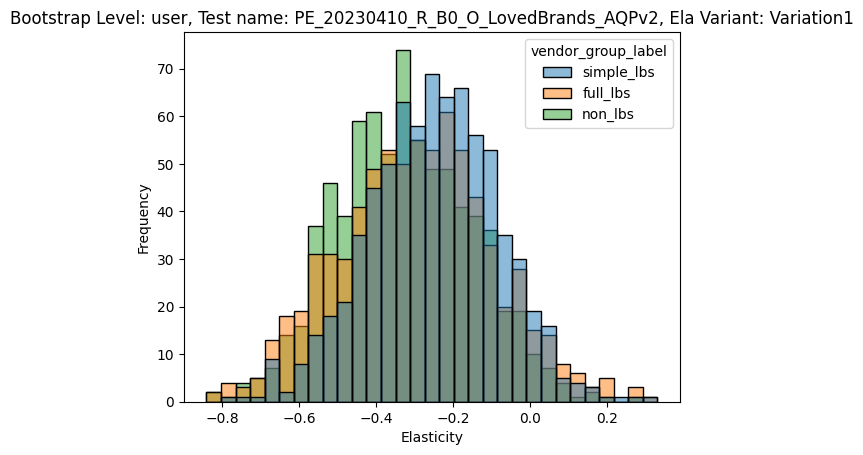

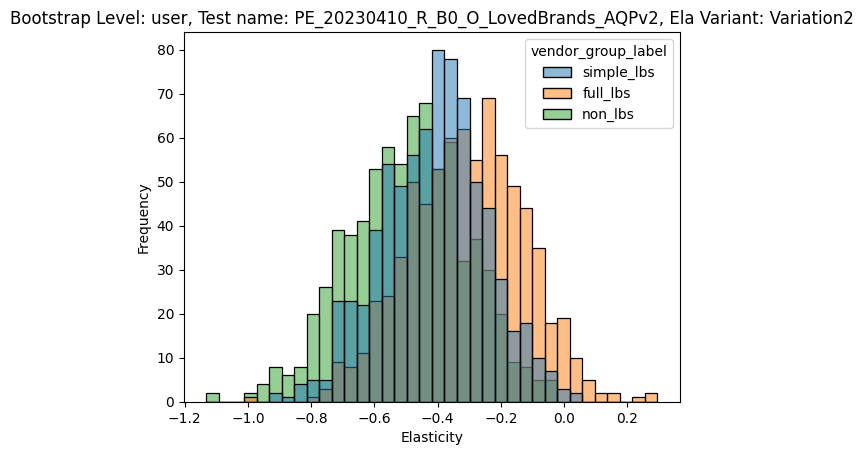

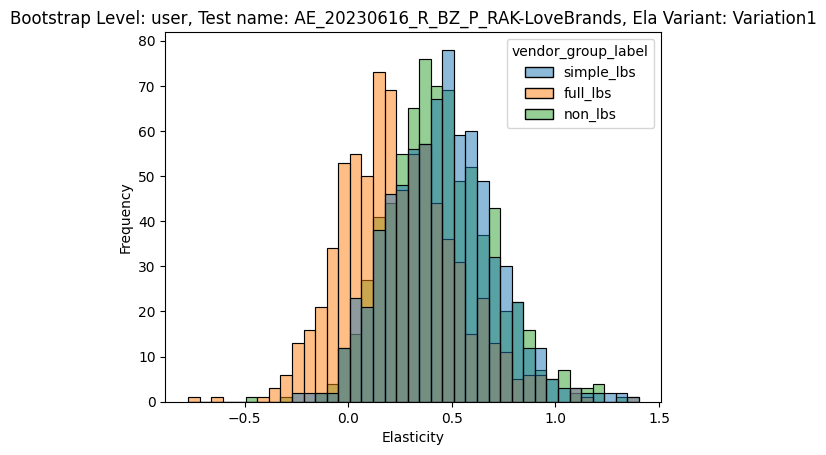

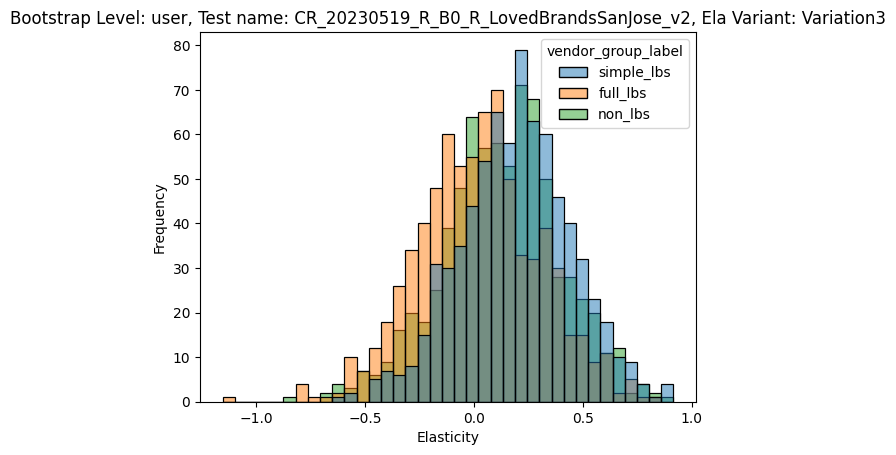

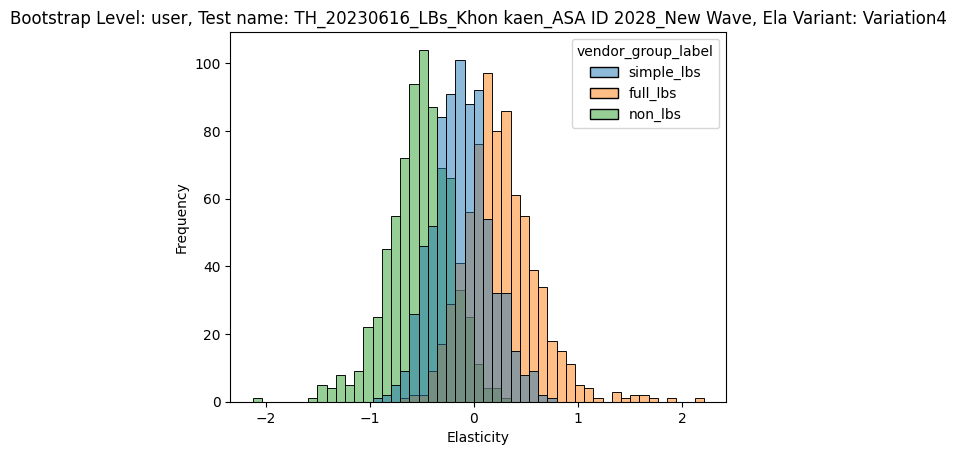

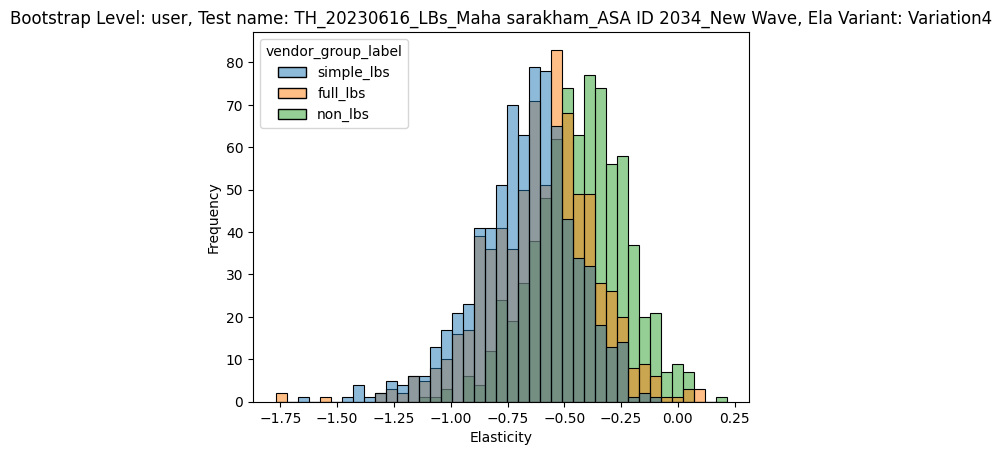

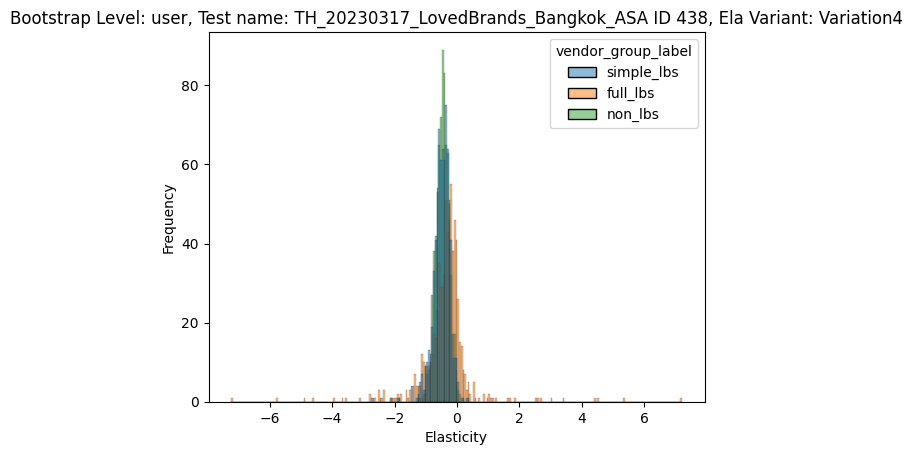

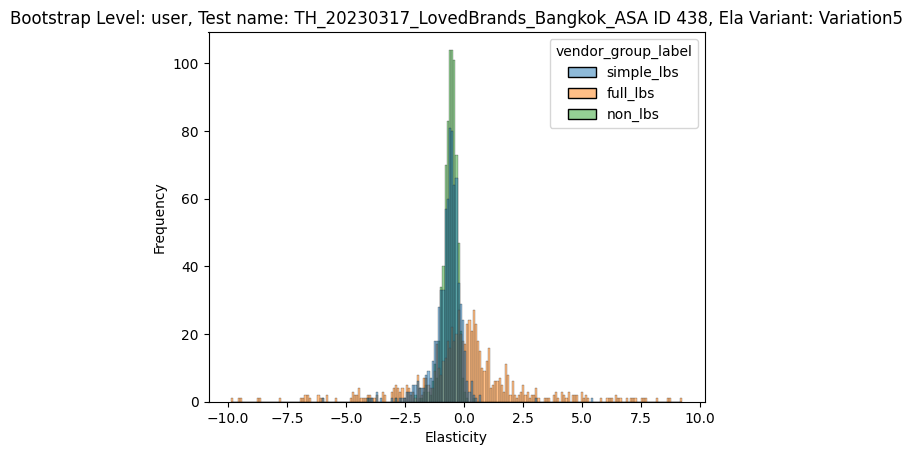

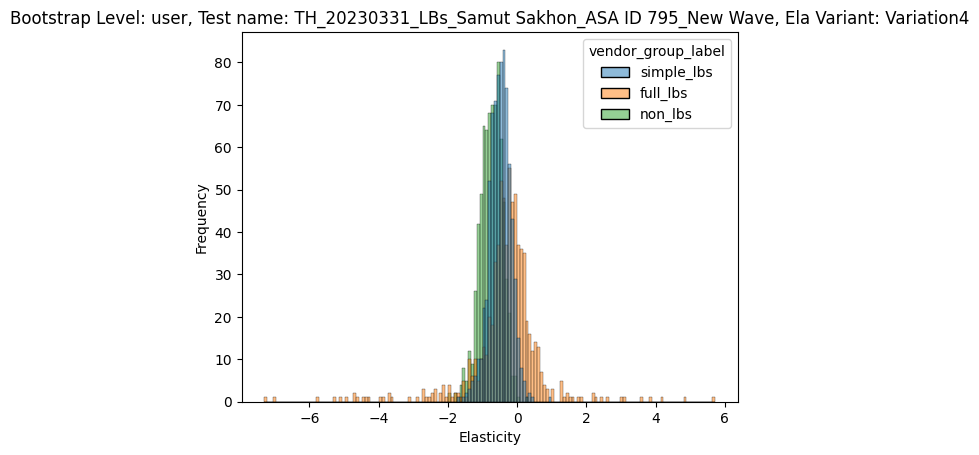

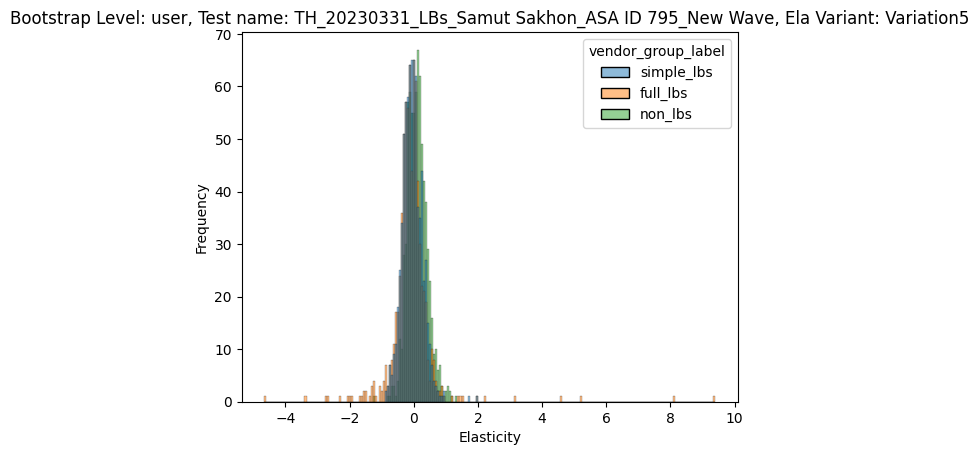

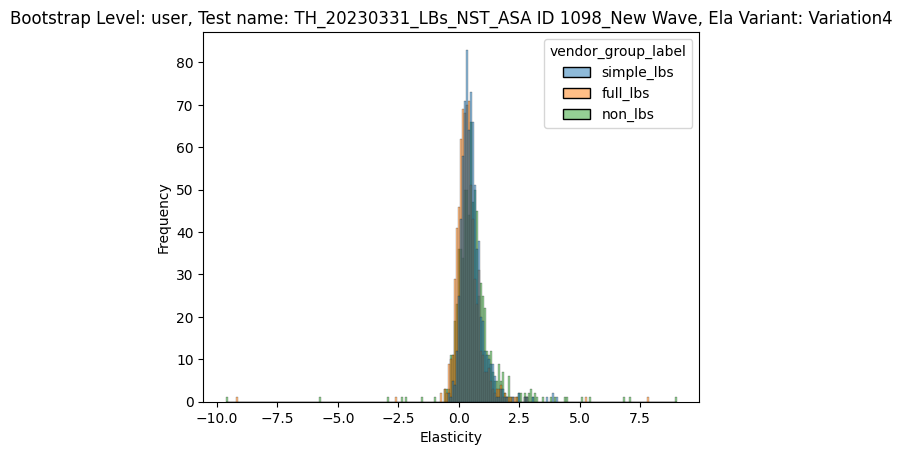

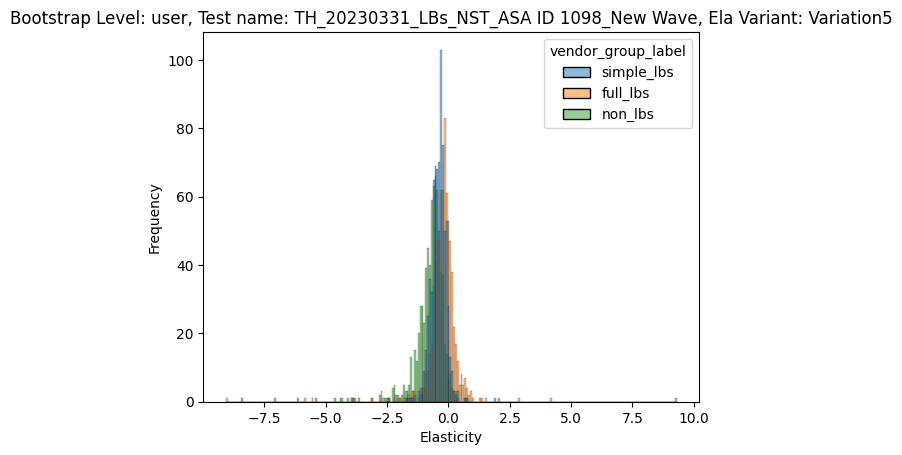

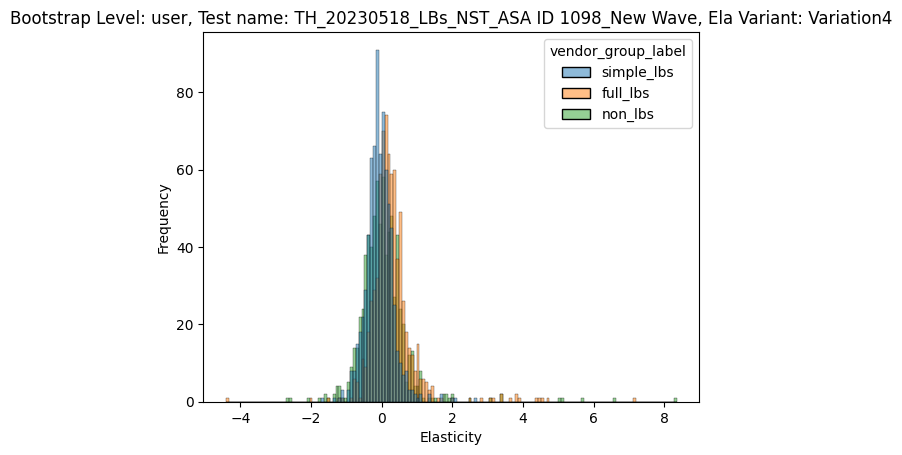

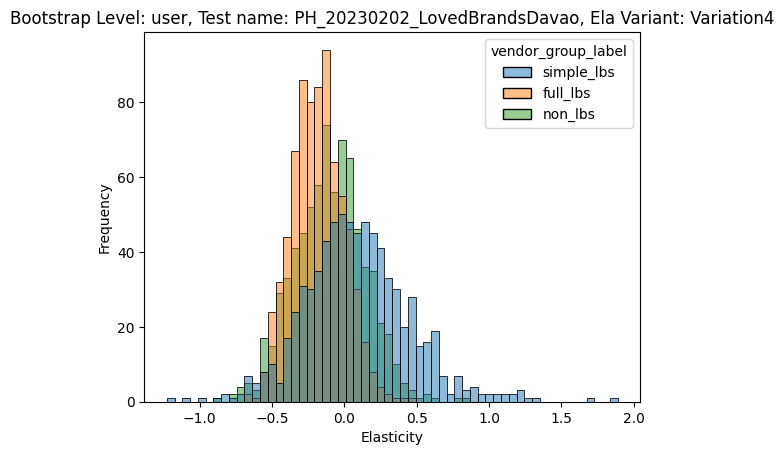

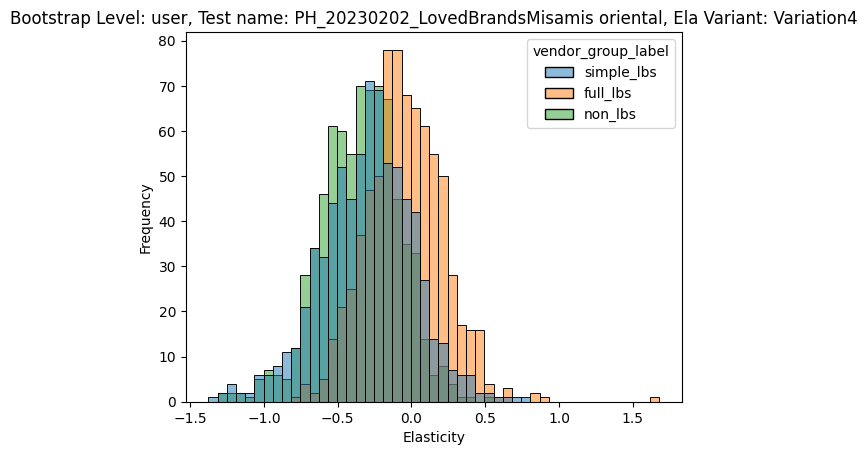

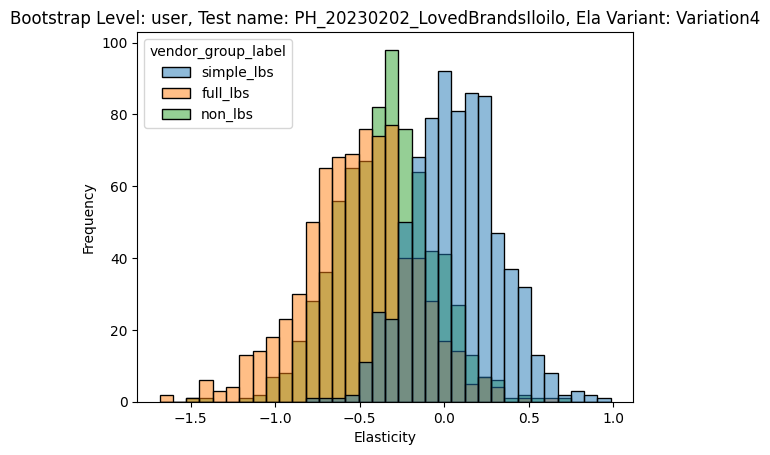

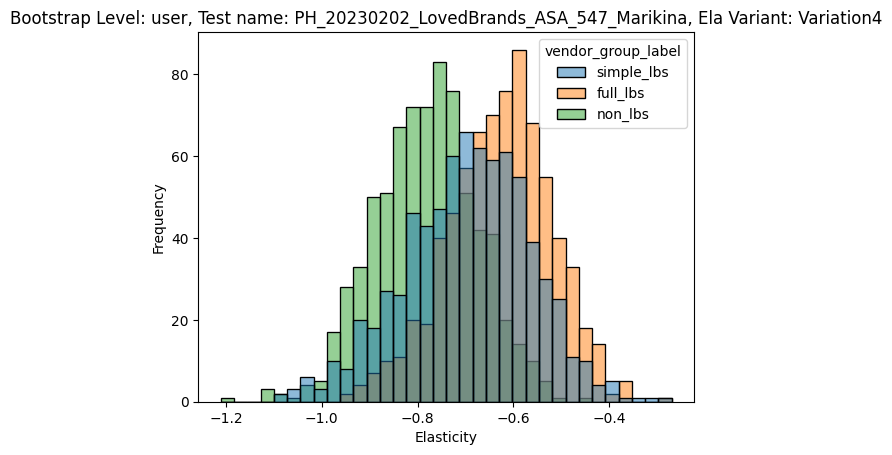

<Figure size 640x480 with 0 Axes>

In [19]:
def generate_plot():
    # Create a data frame showing the total number of test/ela_variant combinations to loop over
    loop_combos = df_sim_results[["test_name", "ela_variant"]].drop_duplicates().reset_index(drop=True)
    
    # Extract the tests to loop over
    loop_tests = df_sim_results["test_name"].drop_duplicates().reset_index(drop=True)
    
    # Extract the bootstrap levels to loop over
    loop_bootstrap_lvls = df_sim_results["bootstrap_level"].drop_duplicates().reset_index(drop=True)

    # Iterate over price tier values and create the histograms
    for boot in loop_bootstrap_lvls:
        for com in loop_tests:
            loop_var = loop_combos[loop_combos["test_name"]==com]["ela_variant"].tolist()
            for var in loop_var:
                df_iter = df_sim_results[
                    (df_sim_results["bootstrap_level"] == boot) &
                    (df_sim_results["test_name"] == com) &
                    (df_sim_results["ela_variant"] == var) &
                    (df_sim_results["elasticity"] >= ela_lower_limit) &
                    (df_sim_results["elasticity"] <= ela_upper_limit)
                ]
                sns.histplot(data=df_iter, x="elasticity", hue="vendor_group_label", hue_order=vendor_labels)
                plt.title(f"Bootstrap Level: {boot}, Test name: {com}, Ela Variant: {var}")
                plt.xlabel("Elasticity")
                plt.ylabel("Frequency")
                plt.show()

    # Adjust the space between the subplots
    plt.tight_layout()

# Invoke the plotting function
generate_plot()

### PLEASE USE THIS WITH CAUTION BECAUSE IT PUSHES DATA TO BQ

In [17]:
# Push the results to BigQuery
job_config = bigquery.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
client.load_table_from_dataframe(
    dataframe=df_sim_results,
    destination="logistics-data-storage-staging.long_term_pricing.lb_elasticity_tests_sim_results",
    job_config=job_config
)

LoadJob<project=logistics-customer-staging, location=US, id=1664ea55-d053-48ce-b2cd-36d60f0959da>